## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_{inf}}{T_{b} - T_{{inf}}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{inf})}$


- $\epsilon_G=\epsilon(T_b-T_{inf})$


- $\epsilon_C=\beta(T_b-T_{inf})$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

In [11]:
eg = .6
ec = 0.4
N = 1.

## Import libraries 

In [12]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import scipy.io
from torchinfo import summary


## Hyper-parameters

In [13]:
seed_id = 1234
steps = 30000
lr = 4e-3
nneurons = 20
nhiden_layers = 8
N_f = 50 #Total number of collocation points 
offset = .0001
G_init = 1.
print("Our guess o G is :", G_init)
device = 'cpu'

Our guess o G is : 1.0


### Set random seed and select device

In [14]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(seed_id)

# Random number generators in other libraries
np.random.seed(seed_id)

## Load data

In [15]:
relative_csv_path = "./../src/data/raw/heat_transfer_finn.csv"

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df_T.sample()
print('The data used is form the sample:',random_sample.index[0])
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy().T
X_real = np.linspace(0,1,T_real.shape[0]).reshape(-1,1)
X_real = X_real.astype(np.float32)
X_bc = X_real[-1].reshape(-1,1)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)])
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)

The data used is form the sample: 67
G_real is: [[0.70303543]]


### Collocation points ($loss_f$) and auxiliary loss vectors

In [16]:
# colocation points to evaluate PDE loss
f_hat = torch.zeros(N_f,1).to(device)
# axuliary theta to evaluate the boundary condition loss
theta_x_hat = torch.zeros(1,1).to(device)
# axuliary G to evaluate a costraint G value
lossG_hat = torch.zeros(1,1).to(device)
#
X_train_f = torch.linspace(lb[0] + offset,ub[0] - offset,N_f).reshape(-1,1)
print("The number of collocation points are", N_f)

The number of collocation points are 50


## Define architecture 

In [17]:
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])
print("The number of layers selected are", layers.size-1)

The number of layers selected are 9


## DNN class

In [20]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
            
        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## Adapatative DNN class

In [21]:
class TrainableLambdas(nn.Module):
    def __init__(self, num_units):
        super().__init__()
        self.lambda_params = nn.Parameter(torch.ones(num_units))
    def forward(self, x):
        return self.lambda_params * x

#  Deep Neural Network with adaptative activation functions
class AdaptativeDNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        
        'activation function'
        self.activation = nn.Tanh()
        
        self.lambdas = [TrainableLambdas(layers[i]) for i in range(1, len(layers) - 1)]
        
        for i,layer_coef in enumerate(self.lambdas):
            param_name = 'Lambda' + str(i)
            self.register_parameter(param_name, layer_coef.lambda_params)
        
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
            
        #convert to float
        a = x.float()

        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            a = self.linears[i](a)
                        
            a = self.activation(a)
            
            lambdas_layer = self.lambdas[i]
            
            a = lambdas_layer(a)
        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

### Test that alpha parameters are being added by clases constructors

In [24]:
# Print adaptative NN summary
adaptative_NN = AdaptativeDNN(layers)
print("The vnailla adaptatative NN summary is:") 
print(summary(adaptative_NN))

vanilla_NN = DNN(layers)
print("The vnailla NN summary is:")
print(summary(vanilla_NN))

The vnailla adaptatative NN summary is:
Layer (type:depth-idx)                   Param #
AdaptativeDNN                            160
├─Tanh: 1-1                              --
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       40
│    └─Linear: 2-2                       420
│    └─Linear: 2-3                       420
│    └─Linear: 2-4                       420
│    └─Linear: 2-5                       420
│    └─Linear: 2-6                       420
│    └─Linear: 2-7                       420
│    └─Linear: 2-8                       420
│    └─Linear: 2-9                       21
Total params: 3,161
Trainable params: 3,161
Non-trainable params: 0
The vnailla NN summary is:
Layer (type:depth-idx)                   Param #
DNN                                      --
├─Tanh: 1-1                              --
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       40
│    └─Linear: 2-2                       420
│    └─Lin

## PINN class

In [25]:
class PINN():
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='sum')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G_init)], requires_grad=True).float().to(device)  
                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "G": [],
                             "Total":[]}
        
        'Parameters trials'
        self.params_history = {"G": [] }

    def loss_data(self, x, theta_real, save = False):
                   
        if torch.is_tensor(theta_real) != True:         
            theta_real = torch.from_numpy(theta_real)
        
        theta_nn = self.dnn(x)
        loss_d = self.loss_function(theta_nn, theta_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, x_f, save = False):
                       
        # extract the PDE parameters
        G = self.G

        # clone the input data and add AD
        x = x_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x

        aux_x = autograd.grad(aux, x, torch.ones(x_f.shape).to(device), create_graph=True)[0]
        
        # PDE f  = 0
        f = aux_x - N**2*theta + N**2*G*(1 + eg*theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f, f_hat)
        
        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 

        return loss_f
    
    def loss_BC(self,x_bc, save = False):
        
        if torch.is_tensor(x_bc) != True:         
            x_bc = torch.from_numpy(x_bc)

        # clone the input data and add AD
        x = x_bc.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_bc.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        loss_bc = self.loss_function(theta_x, theta_x_hat)
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    
    def loss_G(self, save = False):
        lossG = 0.0
        G_NN = self.G
        if G_NN < 1e-5:
            K = 1000
            lossG = K * G_NN**2

        lossG = self.loss_function(torch.Tensor([lossG]), lossG_hat)
            

        save and self.loss_history["G"].append(lossG)
                
        return lossG
        
    def loss(self, x_real, theta_real, x_f, x_bc, save = False):

        loss_d  = self.loss_data(x_real, theta_real, save)
        loss_f  = self.loss_PDE(x_f, save)
        loss_bc = self.loss_BC(x_bc, save)
        loss_g = self.loss_G(save)
        
        # weights should sum 1
        loss_val = loss_d + loss_f + loss_bc + loss_g

        if save:
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
            self.params_history["G"].append(self.G.to('cpu').data.numpy().copy())

        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_real, Theta_real, X_train_f, X_bc, True)
        
        loss.backward()
        
        self.iter += 1

        print(
            'LBFGS iter: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
            (   
                self.iter,
                loss.cpu().detach().numpy(),
                G_real,
                self.G.item(),
            )
        )

        
        return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network with the norm '
    def test(self):
                
        theta_pred = self.dnn(X_real)
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)  
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

## Train the vanila model


In [244]:
'Neural Network Summary'
pinn_adam = PINN(layers)

'Neural Network Parameters'
params = list(pinn_adam.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)


'Store losses and predicted G values'
G_hist = np.zeros((steps,))

'Train the model'
for epoch in range(steps):
    if epoch%(steps // 100) == 0:
        print('Voy en la vuelta número {} y G = {}'.format(epoch-1,G_hist[epoch-1]))
    # compute net U prediction
    theta_nn = pinn_adam.dnn(X_real)
    loss = pinn_adam.loss(X_real, Theta_real, X_train_f, X_bc, True)
    # store parameters 
    G_hist[epoch], N_hist[epoch], ec_hist[epoch], eg_hist[epoch]  = pinn_adam.G, pinn_adam.N, pinn_adam.ec, pinn_adam.eg
    
    # increment the counter 
    pinn_adam.iter +=1 
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn_adam.test()


Voy en la vuelta número -1 y G = 0.0
Voy en la vuelta número 299 y G = 0.4899204671382904
Voy en la vuelta número 599 y G = 0.4793577790260315
Voy en la vuelta número 899 y G = 0.4688534438610077
Voy en la vuelta número 1199 y G = 0.4568530023097992
Voy en la vuelta número 1499 y G = 0.4438754916191101
Voy en la vuelta número 1799 y G = 0.4310755431652069
Voy en la vuelta número 2099 y G = 0.41837719082832336
Voy en la vuelta número 2399 y G = 0.4054982662200928
Voy en la vuelta número 2699 y G = 0.39280909299850464
Voy en la vuelta número 2999 y G = 0.3808134198188782
Voy en la vuelta número 3299 y G = 0.3727845549583435
Voy en la vuelta número 3599 y G = 0.3624039888381958
Voy en la vuelta número 3899 y G = 0.35695961117744446
Voy en la vuelta número 4199 y G = 0.34771329164505005
Voy en la vuelta número 4499 y G = 0.3435356318950653
Voy en la vuelta número 4799 y G = 0.3385317623615265
Voy en la vuelta número 5099 y G = 0.33242249488830566
Voy en la vuelta número 5399 y G = 0.324828

# Losses vs num epochs 

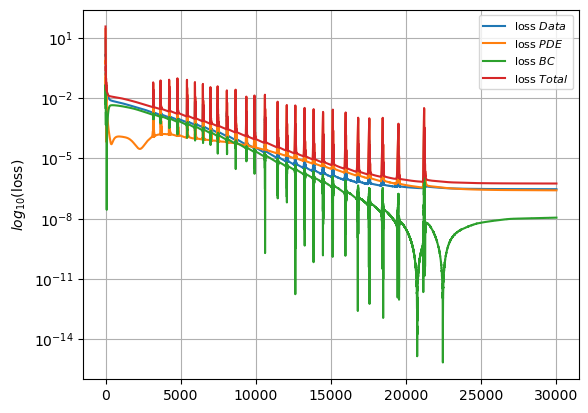

In [245]:
plt.cla()
plt.plot(pinn_adam.loss_history["Data"] , label = r'loss $Data$')
plt.plot(pinn_adam.loss_history["PDE"] , label = r'loss $PDE$')
plt.plot(pinn_adam.loss_history["BC"] , label = r'loss $BC$')
plt.plot(pinn_adam.loss_history["Total"] , label = r'loss $Total$')

plt.legend(loc='upper right', prop={'size': 8})
# plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

[[0.32634646]]


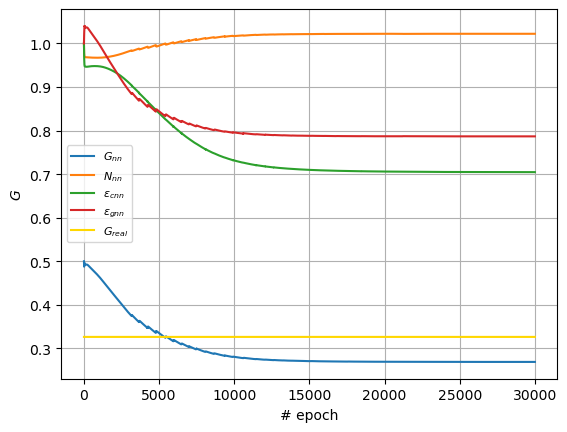

In [246]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')
print(G_real)
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")

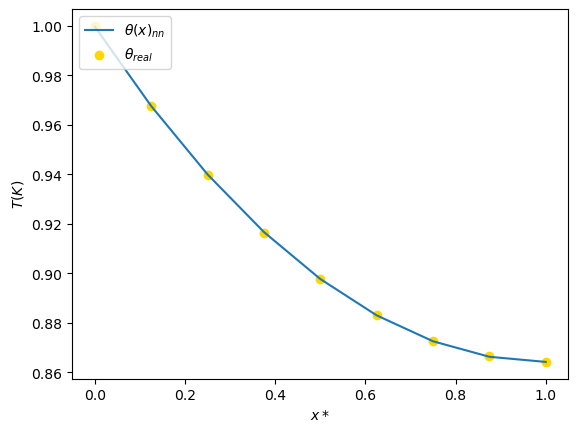

In [247]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn_adam.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='upper left', prop={'size': 10})

## Train with LBFGS

In [248]:
'Neural Network Summary'
pinn_LBFGS = PINN(layers)

'Neural Network Parameters'
params = list(pinn_LBFGS.dnn.parameters())

'''Optimization'''

'Store losses and predicted G values'
# loss_theta = np.zeros((steps,))
# loss_f = np.zeros((steps,))
# loss_bc = np.zeros((steps,))
# loss_hist = [ ]
# G_hist = np.zeros((steps,))
# N_hist = np.zeros((steps,))
# ec_hist = np.zeros((steps,))
# eg_hist = np.zeros((steps,))

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(pinn_LBFGS.closure)


print(pinn_LBFGS.iter)

# 'Train the model'
# for epoch in range(steps):
    
#     if (epoch)%(steps // 100) == 0:
        
#         print(
#             'Epoch: %.0d, G =  %.2f, loss_bc = %.6f, loss_d = %.6f, loss_pde = %.6f' %
#             (
#             epoch,
#             G_hist[epoch],
#             loss_bc[epoch],
#             loss_theta[epoch],
#             loss_f[epoch]
#             )
#         )
        
    
# #     test_error, _ = pinn_LBFGS.test()


351


# Losses vs num epochs 

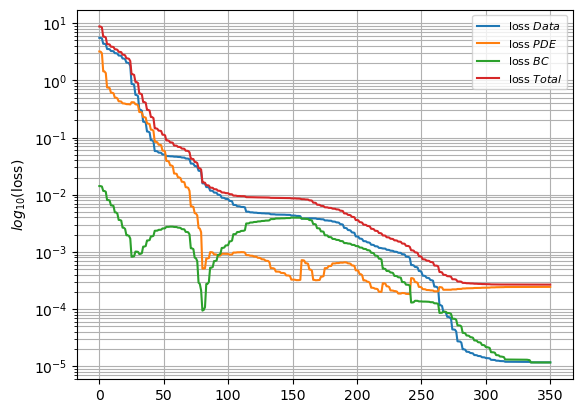

In [249]:
plt.cla()
# plt.plot(range(steps),loss_theta, label = r'loss $\theta_{nn} - \theta_{m}$')
# plt.plot(range(steps),loss_f, label = r'loss $f_{PDE}$')
plt.plot(pinn_LBFGS.loss_history["Data"] , label = r'loss $Data$')
plt.plot(pinn_LBFGS.loss_history["PDE"] , label = r'loss $PDE$')
plt.plot(pinn_LBFGS.loss_history["BC"] , label = r'loss $BC$')
# plt.plot(pinn_LBFGS.loss_history["G"] , label = r'loss $G$')
plt.plot(pinn_LBFGS.loss_history["Total"] , label = r'loss $Total$')

plt.legend(loc='upper right', prop={'size': 8})
# plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

## PDE Parameters ($G$, $N$, $\epsilon_c$, $\epsilon_g$) value vs num epochs

Greal is: [[0.32634646]]
G_NN is: Parameter containing:
tensor([0.1741], requires_grad=True)


351

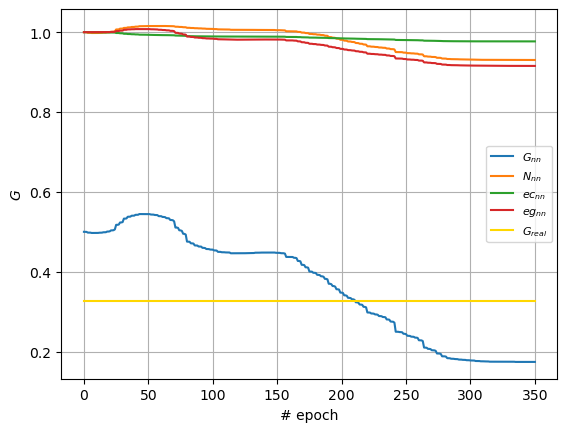

In [250]:
plt.cla()
LBFGS_steps = len(pinn_LBFGS.params_history["eg"])
plt.plot(pinn_LBFGS.params_history["G"] ,label = r'$G_{nn}$')
plt.plot(pinn_LBFGS.params_history["N"] ,label = r'$N_{nn}$')
plt.plot(pinn_LBFGS.params_history["ec"] ,label = r'$ec_{nn}$')
plt.plot(pinn_LBFGS.params_history["eg"] ,label = r'$eg_{nn}$')
print("Greal is:",G_real)
print("G_NN is:",pinn_LBFGS.G)
plt.plot(range(LBFGS_steps), G_real*np.ones((LBFGS_steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")
len(pinn_LBFGS.params_history["eg"])

##  Plot $\theta(x)$ solution

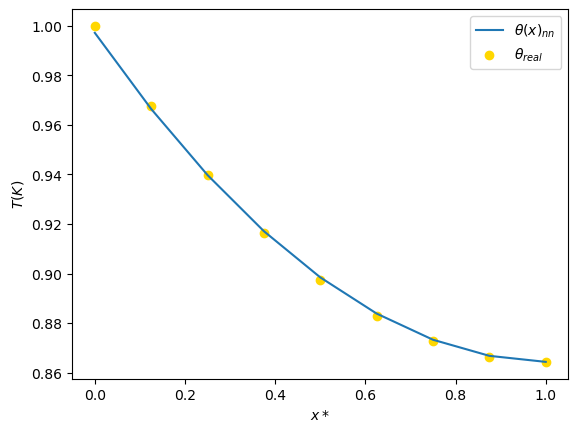

In [251]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn_LBFGS.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='best', prop={'size': 10})


In [17]:
print(pinn_LBFGS.G, pinn_LBFGS.ec, pinn_LBFGS.eg, pinn_LBFGS.N)

Parameter containing:
tensor([0.0022], requires_grad=True) Parameter containing:
tensor([0.9386], requires_grad=True) Parameter containing:
tensor([0.7155], requires_grad=True) Parameter containing:
tensor([0.7577], requires_grad=True)


## Make some noise! 

In [252]:
deviation_T =  T_real.std()
alpha_dev = .1
noise_dev_std = deviation_T * alpha_dev 

T_real_noisy = torch.from_numpy(T_real) 
noise_T = torch.normal(0, noise_dev_std, T_real.shape)
T_real_noisy += noise_T
Theta_noisy = torch.multiply(torch.add(T_real_noisy, torch.tensor([-T_inf])), torch.tensor([1/(T_b - T_inf)]))
# Hardcode the dirichlet bc value 
Theta_noisy[0] = 1.0
Theta_noisy = Theta_noisy.type(torch.Tensor)
'Neural Network Summary'
pinn = PINN(layers)

'Neural Network Parameters'
params = list(pinn.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)

'Store losses and predicted G values'
loss_theta = np.zeros((steps,))
loss_f = np.zeros((steps,))
loss_bc = np.zeros((steps,))
loss_hist = np.zeros((steps,))
G_hist = np.zeros((steps,))
N_hist = np.zeros((steps,))
ec_hist = np.zeros((steps,))
eg_hist = np.zeros((steps,))

'Train the model'
for epoch in range(steps):
    if epoch%(steps//100) == 0:
        print('Voy en la vuelta número {} y G = {}'.format(epoch-1,G_hist[epoch - 1]))
    # compute net U prediction
    theta_nn = pinn.dnn(X_real)
    # compute losses
    loss_theta[epoch] = pinn.loss_data(X_real, Theta_noisy).to('cpu').detach().numpy()
    loss_f[epoch]     = pinn.loss_PDE(X_train_f).to('cpu').detach().numpy()
    loss_bc[epoch]    = pinn.loss_BC(X_bc).to('cpu').detach().numpy()
    loss = pinn.loss(X_real, Theta_noisy, X_train_f,X_bc)
    loss_hist[epoch] = loss.to('cpu').detach().numpy()
    # store parameters 
    G_hist[epoch], N_hist[epoch], ec_hist[epoch], eg_hist[epoch]  = pinn.G, pinn.N, pinn.ec, pinn.eg
    
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn.test()


Voy en la vuelta número -1 y G = 0.0
Voy en la vuelta número 19 y G = 0.49010440707206726
Voy en la vuelta número 39 y G = 0.49761879444122314
Voy en la vuelta número 59 y G = 0.49469560384750366
Voy en la vuelta número 79 y G = 0.4941442012786865
Voy en la vuelta número 99 y G = 0.49431872367858887
Voy en la vuelta número 119 y G = 0.4941027760505676
Voy en la vuelta número 139 y G = 0.49431395530700684
Voy en la vuelta número 159 y G = 0.49455156922340393
Voy en la vuelta número 179 y G = 0.4948197603225708
Voy en la vuelta número 199 y G = 0.4950495660305023
Voy en la vuelta número 219 y G = 0.49522271752357483
Voy en la vuelta número 239 y G = 0.49531856179237366
Voy en la vuelta número 259 y G = 0.4953335225582123
Voy en la vuelta número 279 y G = 0.495269238948822
Voy en la vuelta número 299 y G = 0.4951324164867401
Voy en la vuelta número 319 y G = 0.4949319660663605
Voy en la vuelta número 339 y G = 0.49467775225639343
Voy en la vuelta número 359 y G = 0.4943794310092926
Voy en

Voy en la vuelta número 3039 y G = 0.43042200803756714
Voy en la vuelta número 3059 y G = 0.4297853708267212
Voy en la vuelta número 3079 y G = 0.42914342880249023
Voy en la vuelta número 3099 y G = 0.4284960925579071
Voy en la vuelta número 3119 y G = 0.4278431832790375
Voy en la vuelta número 3139 y G = 0.4271846115589142
Voy en la vuelta número 3159 y G = 0.4265201687812805
Voy en la vuelta número 3179 y G = 0.4258496165275574
Voy en la vuelta número 3199 y G = 0.4251730740070343
Voy en la vuelta número 3219 y G = 0.4244902729988098
Voy en la vuelta número 3239 y G = 0.42380109429359436
Voy en la vuelta número 3259 y G = 0.42310550808906555
Voy en la vuelta número 3279 y G = 0.42240336537361145
Voy en la vuelta número 3299 y G = 0.4216945767402649
Voy en la vuelta número 3319 y G = 0.4209790825843811
Voy en la vuelta número 3339 y G = 0.42025694251060486
Voy en la vuelta número 3359 y G = 0.4195280075073242
Voy en la vuelta número 3379 y G = 0.4187922775745392
Voy en la vuelta númer

Voy en la vuelta número 6079 y G = 0.3437957763671875
Voy en la vuelta número 6099 y G = 0.3431844115257263
Voy en la vuelta número 6119 y G = 0.3425773084163666
Voy en la vuelta número 6139 y G = 0.34197360277175903
Voy en la vuelta número 6159 y G = 0.34137287735939026
Voy en la vuelta número 6179 y G = 0.3407750427722931
Voy en la vuelta número 6199 y G = 0.3401801884174347
Voy en la vuelta número 6219 y G = 0.33958834409713745
Voy en la vuelta número 6239 y G = 0.33899953961372375
Voy en la vuelta número 6259 y G = 0.3384138345718384
Voy en la vuelta número 6279 y G = 0.3378312587738037
Voy en la vuelta número 6299 y G = 0.3372519314289093
Voy en la vuelta número 6319 y G = 0.33667585253715515
Voy en la vuelta número 6339 y G = 0.33610305190086365
Voy en la vuelta número 6359 y G = 0.33553358912467957
Voy en la vuelta número 6379 y G = 0.3349674940109253
Voy en la vuelta número 6399 y G = 0.3344047963619232
Voy en la vuelta número 6419 y G = 0.3338455557823181
Voy en la vuelta núme

Voy en la vuelta número 9119 y G = 0.29326173663139343
Voy en la vuelta número 9139 y G = 0.2930569052696228
Voy en la vuelta número 9159 y G = 0.2928541302680969
Voy en la vuelta número 9179 y G = 0.2926534116268158
Voy en la vuelta número 9199 y G = 0.2924547791481018
Voy en la vuelta número 9219 y G = 0.2922581434249878
Voy en la vuelta número 9239 y G = 0.29206353425979614
Voy en la vuelta número 9259 y G = 0.29187098145484924
Voy en la vuelta número 9279 y G = 0.2916804552078247
Voy en la vuelta número 9299 y G = 0.291491836309433
Voy en la vuelta número 9319 y G = 0.29130521416664124
Voy en la vuelta número 9339 y G = 0.2911205291748047
Voy en la vuelta número 9359 y G = 0.2909378409385681
Voy en la vuelta número 9379 y G = 0.2907569706439972
Voy en la vuelta número 9399 y G = 0.29057806730270386
Voy en la vuelta número 9419 y G = 0.29040101170539856
Voy en la vuelta número 9439 y G = 0.2902258336544037
Voy en la vuelta número 9459 y G = 0.29005250334739685
Voy en la vuelta númer

Voy en la vuelta número 12119 y G = 0.279386967420578
Voy en la vuelta número 12139 y G = 0.27935686707496643
Voy en la vuelta número 12159 y G = 0.2793055474758148
Voy en la vuelta número 12179 y G = 0.27924928069114685
Voy en la vuelta número 12199 y G = 0.27919355034828186
Voy en la vuelta número 12219 y G = 0.2791384160518646
Voy en la vuelta número 12239 y G = 0.27908387780189514
Voy en la vuelta número 12259 y G = 0.2790299654006958
Voy en la vuelta número 12279 y G = 0.2789766192436218
Voy en la vuelta número 12299 y G = 0.2789239287376404
Voy en la vuelta número 12319 y G = 0.27887171506881714
Voy en la vuelta número 12339 y G = 0.2788201570510864
Voy en la vuelta número 12359 y G = 0.2787691652774811
Voy en la vuelta número 12379 y G = 0.2787187993526459
Voy en la vuelta número 12399 y G = 0.27866896986961365
Voy en la vuelta número 12419 y G = 0.278619647026062
Voy en la vuelta número 12439 y G = 0.2785709798336029
Voy en la vuelta número 12459 y G = 0.2785228490829468
Voy en

Voy en la vuelta número 15079 y G = 0.2757522463798523
Voy en la vuelta número 15099 y G = 0.27585741877555847
Voy en la vuelta número 15119 y G = 0.2759056091308594
Voy en la vuelta número 15139 y G = 0.2758888602256775
Voy en la vuelta número 15159 y G = 0.27587294578552246
Voy en la vuelta número 15179 y G = 0.2758536636829376
Voy en la vuelta número 15199 y G = 0.2758345901966095
Voy en la vuelta número 15219 y G = 0.27581602334976196
Voy en la vuelta número 15239 y G = 0.2757975459098816
Voy en la vuelta número 15259 y G = 0.27577918767929077
Voy en la vuelta número 15279 y G = 0.27576103806495667
Voy en la vuelta número 15299 y G = 0.27574312686920166
Voy en la vuelta número 15319 y G = 0.27572548389434814
Voy en la vuelta número 15339 y G = 0.27570804953575134
Voy en la vuelta número 15359 y G = 0.2756907641887665
Voy en la vuelta número 15379 y G = 0.2756738066673279
Voy en la vuelta número 15399 y G = 0.27565687894821167
Voy en la vuelta número 15419 y G = 0.2756401300430298
V

Voy en la vuelta número 18039 y G = 0.27515730261802673
Voy en la vuelta número 18059 y G = 0.2751522958278656
Voy en la vuelta número 18079 y G = 0.2751413881778717
Voy en la vuelta número 18099 y G = 0.27512940764427185
Voy en la vuelta número 18119 y G = 0.2751174867153168
Voy en la vuelta número 18139 y G = 0.27510586380958557
Voy en la vuelta número 18159 y G = 0.2750944197177887
Voy en la vuelta número 18179 y G = 0.275083065032959
Voy en la vuelta número 18199 y G = 0.27507176995277405
Voy en la vuelta número 18219 y G = 0.2750607430934906
Voy en la vuelta número 18239 y G = 0.27504977583885193
Voy en la vuelta número 18259 y G = 0.2750389873981476
Voy en la vuelta número 18279 y G = 0.275028258562088
Voy en la vuelta número 18299 y G = 0.27501773834228516
Voy en la vuelta número 18319 y G = 0.27500733733177185
Voy en la vuelta número 18339 y G = 0.27499696612358093
Voy en la vuelta número 18359 y G = 0.27498680353164673
Voy en la vuelta número 18379 y G = 0.2749766707420349
Voy

Voy en la vuelta número 20999 y G = 0.2745158076286316
Voy en la vuelta número 21019 y G = 0.2745113968849182
Voy en la vuelta número 21039 y G = 0.27450695633888245
Voy en la vuelta número 21059 y G = 0.27450260519981384
Voy en la vuelta número 21079 y G = 0.27449825406074524
Voy en la vuelta número 21099 y G = 0.2744939923286438
Voy en la vuelta número 21119 y G = 0.27448979020118713
Voy en la vuelta número 21139 y G = 0.27448561787605286
Voy en la vuelta número 21159 y G = 0.27448153495788574
Voy en la vuelta número 21179 y G = 0.2744775414466858
Voy en la vuelta número 21199 y G = 0.2744736671447754
Voy en la vuelta número 21219 y G = 0.2744697630405426
Voy en la vuelta número 21239 y G = 0.2744658887386322
Voy en la vuelta número 21259 y G = 0.2744622826576233
Voy en la vuelta número 21279 y G = 0.2744598090648651
Voy en la vuelta número 21299 y G = 0.2744632363319397
Voy en la vuelta número 21319 y G = 0.27451008558273315
Voy en la vuelta número 21339 y G = 0.27462080121040344
Vo

Voy en la vuelta número 23979 y G = 0.2744032144546509
Voy en la vuelta número 23999 y G = 0.27440035343170166
Voy en la vuelta número 24019 y G = 0.2743975818157196
Voy en la vuelta número 24039 y G = 0.2743947207927704
Voy en la vuelta número 24059 y G = 0.2743920087814331
Voy en la vuelta número 24079 y G = 0.2743891775608063
Voy en la vuelta número 24099 y G = 0.2743862271308899
Voy en la vuelta número 24119 y G = 0.27438291907310486
Voy en la vuelta número 24139 y G = 0.27437853813171387
Voy en la vuelta número 24159 y G = 0.27437397837638855
Voy en la vuelta número 24179 y G = 0.27439600229263306
Voy en la vuelta número 24199 y G = 0.27448028326034546
Voy en la vuelta número 24219 y G = 0.27449917793273926
Voy en la vuelta número 24239 y G = 0.27449485659599304
Voy en la vuelta número 24259 y G = 0.2744928002357483
Voy en la vuelta número 24279 y G = 0.27448874711990356
Voy en la vuelta número 24299 y G = 0.274484783411026
Voy en la vuelta número 24319 y G = 0.27448105812072754
V

Voy en la vuelta número 26939 y G = 0.2744781970977783
Voy en la vuelta número 26959 y G = 0.2744751572608948
Voy en la vuelta número 26979 y G = 0.274472177028656
Voy en la vuelta número 26999 y G = 0.27446919679641724
Voy en la vuelta número 27019 y G = 0.27446621656417847
Voy en la vuelta número 27039 y G = 0.2744632363319397
Voy en la vuelta número 27059 y G = 0.2744602560997009
Voy en la vuelta número 27079 y G = 0.2744573950767517
Voy en la vuelta número 27099 y G = 0.2744545340538025
Voy en la vuelta número 27119 y G = 0.27445173263549805
Voy en la vuelta número 27139 y G = 0.27444905042648315
Voy en la vuelta número 27159 y G = 0.27444636821746826
Voy en la vuelta número 27179 y G = 0.27444368600845337
Voy en la vuelta número 27199 y G = 0.2744411826133728
Voy en la vuelta número 27219 y G = 0.27443867921829224
Voy en la vuelta número 27239 y G = 0.27443599700927734
Voy en la vuelta número 27259 y G = 0.27443334460258484
Voy en la vuelta número 27279 y G = 0.27443090081214905
V

Voy en la vuelta número 29939 y G = 0.2744719684123993
Voy en la vuelta número 29959 y G = 0.27446988224983215
Voy en la vuelta número 29979 y G = 0.274467796087265


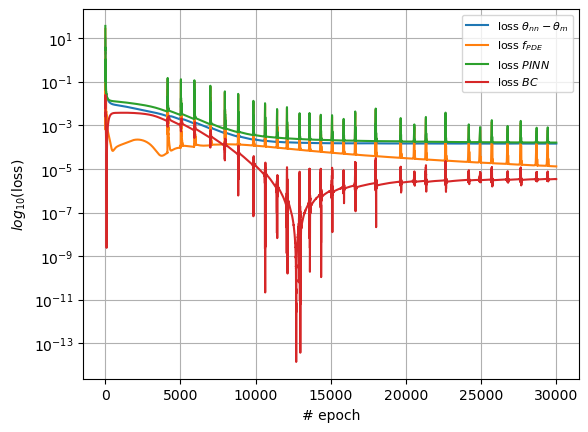

In [253]:
plt.cla()
plt.plot(range(steps),loss_theta, label = r'loss $\theta_{nn} - \theta_{m}$')
plt.plot(range(steps),loss_f, label = r'loss $f_{PDE}$')
plt.plot(range(steps),loss_hist, label = r'loss $PINN$')
plt.plot(range(steps),loss_bc, label = r'loss $BC$')
# plt.plot(range(steps),loss_theta + loss_f)

plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

[[0.32634646]]


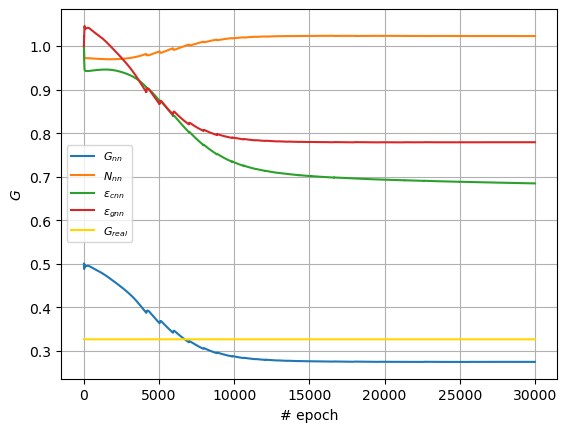

In [254]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')
print(G_real)
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")


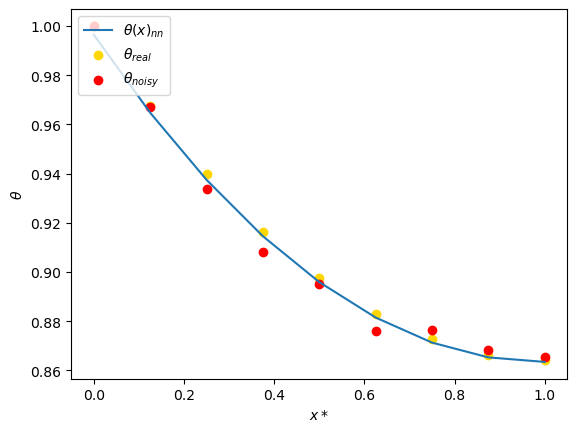

In [255]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
theta_noisy = Theta_noisy.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')
plt.scatter(x_u, theta_noisy, label = r'$\theta_{noisy}$', color = 'red')

plt.xlabel('$x*$')
plt.ylabel(r'$\theta$')
plt.legend(loc='upper left', prop={'size': 10})

## Questions 
- Discutir resultados de la parte a) comentar que encontramos un error al cargar los datos y la relación lineal de G vs \theta
- Se le agrega ruido al $\theta_b$ ?